# Fire Image Dataset
## importing libraries 
    firstly we should import libraries which are necessary for the model to function and for other segments such as data processing , result visualization etc.

In [11]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50 , MobileNet


## Data Loading and Preprocessing
    we define the data_dir variable to specify the directory containing the image dataset. We then load the image dataset using tf.keras.preprocessing.image_dataset_from_directory function. Following that, we filter out any corrupted images from the dataset by iterating over each folder and deleting the corrupted images.

In [3]:
data_dir = '/kaggle/input/fire-dataset/fire_dataset'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 999 files belonging to 2 classes.


In [5]:
import os 
# Iterate through the dataset directory and print the class names
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(class_name)

non_fire_images
fire_images


## Data Augmentation and Generator
    In this segment, we create an ImageDataGenerator object datagen for data augmentation. The datagen is configured with various augmentation parameters such as rotation, width and height shift, shear, zoom, and horizontal flip. The images are also rescaled by dividing by 255. We then specify the image dimensions, batch size, and image shape. Finally, we create separate data generators for training and validation using the flow_from_directory method, which loads the images from the specified directory, performs data augmentation, and provides the images and their corresponding labels.

In [6]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [9]:

num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 2 ....


### image visualization

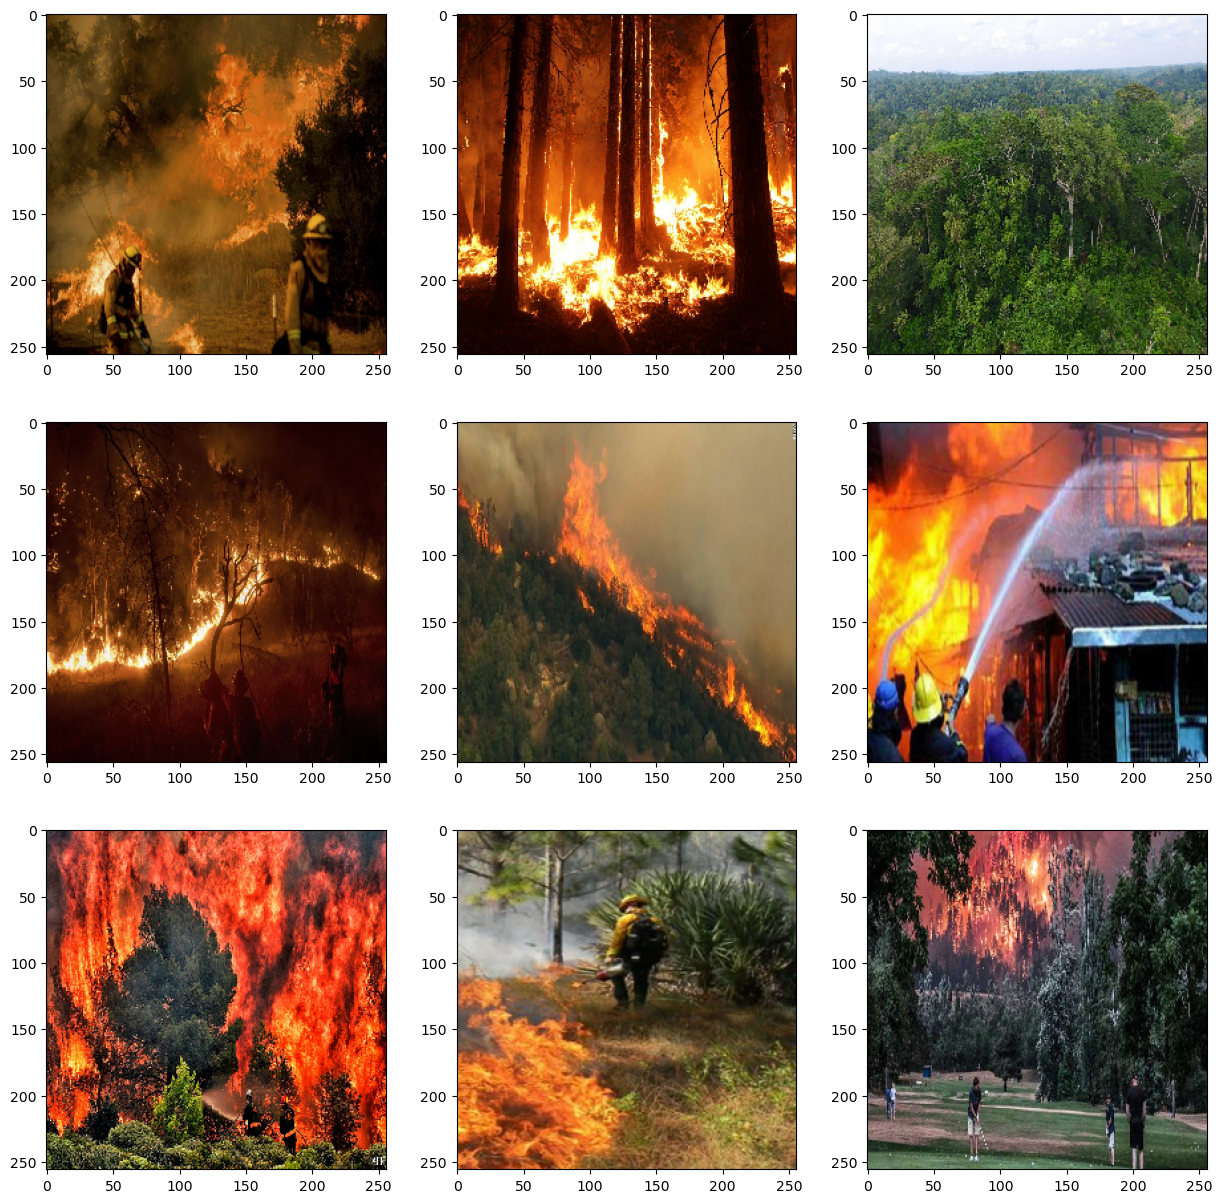

In [10]:

# Define a function to see images
def show_img(data):
    plt.figure(figsize=(15, 15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("on")

# Plot the images in the dataset
show_img(data)

## Training Model - MobileNet

The code in this cell loads the pre-trained InceptionV3 model, freezes its layers, adds custom layers on top, and compiles the model.

The pre-trained VGG16 model is loaded using `tensorflow.keras.applications` with the weights set to 'imagenet' and the fully connected layers excluded (`include_top=False`). The input shape and pooling type are specified as `img_shape` and 'avg' respectively.

Next, the code freezes the weights of all layers in the pre-trained model by setting their `trainable` attribute to `False`. This ensures that the pre-trained weights are not updated during training.

Custom layers are then added on top of the pre-trained model. Batch normalization is applied to normalize the activations, followed by a fully connected layer with 1024 units and ReLU activation. Dropout with a rate of 0.2 is used to reduce overfitting. The final dense layer with `num_classes` units and softmax activation serves as the output layer for classification.

The model is created by specifying the inputs as the input of the pre-trained model and the outputs as the predictions from the custom layers. The model is compiled using the Adam optimizer with a learning rate of 0.001, 'categorical_crossentropy' as the loss function for multi-class classification, and 'accuracy' as the metric for evaluation.

Finally, the model summary is displayed, showing the architecture of the model, the output shapes of each layer, and the number of parameters in each layer.


In [12]:
# Load pre-trained VGG16
pre_trained =  MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')


17225924/17225924 [==============================] - 0s 0us/step


In [28]:
# Assuming you have loaded the pre-trained model and specified num_classes
# and the input shape of your data.

# Freeze the layers in the pre-trained model
for layer in pre_trained.layers:
    layer.trainable = False

# Add additional layers
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)  # Add a dense layer instead of GlobalAveragePooling2D
x = Dropout(0.5)(x)  # Experiment with dropout rate
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=pre_trained.input, outputs=predictions)

# Optionally use a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 114, 114, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 114, 114, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 114, 114, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 114, 114, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 114, 114, 32)     128       
 ation)                                                    

### Model fitting 

train the model using `fit_generator` with training and validation data generators. It calculate the steps per epoch and validation steps, then train the model for 10 epochs, displaying progress and metrics. The training history is stored in the `history` variable.

In [29]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)

Epoch 1/15
25/25 [==============================] - 32s 1s/step - loss: 0.2785 - accuracy: 0.8988 - val_loss: 1.6443 - val_accuracy: 0.7588
Epoch 2/15
25/25 [==============================] - 28s 1s/step - loss: 0.1245 - accuracy: 0.9638 - val_loss: 0.7905 - val_accuracy: 0.8492
Epoch 3/15
25/25 [==============================] - 27s 1s/step - loss: 0.0693 - accuracy: 0.9775 - val_loss: 0.8021 - val_accuracy: 0.8191
Epoch 4/15
25/25 [==============================] - 28s 1s/step - loss: 0.0765 - accuracy: 0.9800 - val_loss: 0.3038 - val_accuracy: 0.9347
Epoch 5/15
25/25 [==============================] - 28s 1s/step - loss: 0.0688 - accuracy: 0.9850 - val_loss: 0.2302 - val_accuracy: 0.9447
Epoch 6/15
25/25 [==============================] - 28s 1s/step - loss: 0.0631 - accuracy: 0.9825 - val_loss: 0.2541 - val_accuracy: 0.9447
Epoch 7/15
25/25 [==============================] - 28s 1s/step - loss: 0.0890 - accuracy: 0.9737 - val_loss: 0.3216 - val_accuracy: 0.9397
Epoch 8/15
25/25 [==

## plotting the graph 

This code plots the training and validation loss and accuracy over the epochs. The loss and accuracy values from the `history` object are used to create line plots. The x-axis represents the epoch number, while the y-axis represents the loss or accuracy. Separate plots are created for training and validation data, and legends are added to differentiate them.

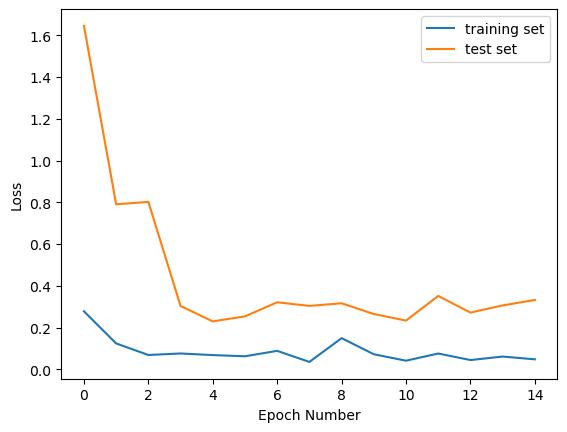

In [30]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

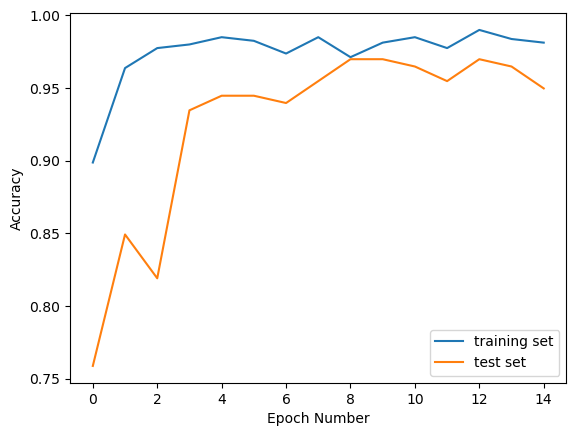

In [31]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### saving the model 

In [32]:
model_name = 'fire_image_recognition(inceptionV3).h5'
model.save(model_name, save_format='h5')

In [33]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

### image label and prediction and visualization

In [34]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='green')
    plt.imshow(img_array)

1/1 [==============================] - 1s 598ms/step


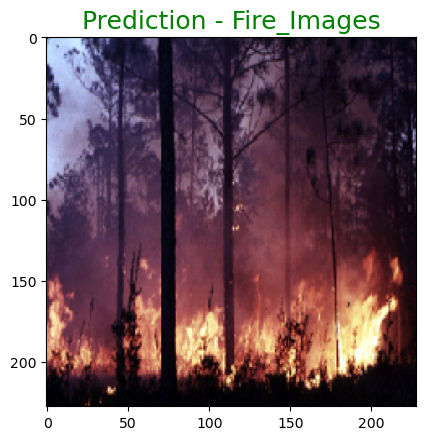

In [52]:
predict_image('/kaggle/input/fire-dataset/fire_dataset/fire_images/fire.113.png', model)

1/1 [==============================] - 0s 22ms/step


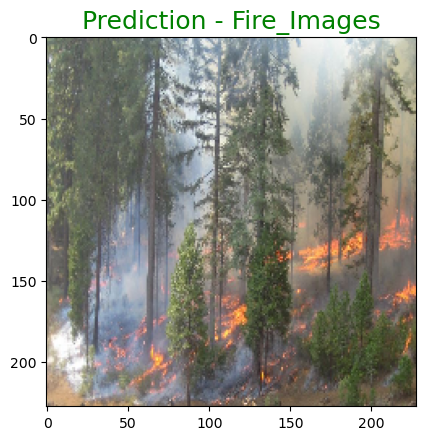

In [53]:
predict_image('/kaggle/input/fire-dataset/fire_dataset/fire_images/fire.125.png', model)

1/1 [==============================] - 0s 23ms/step


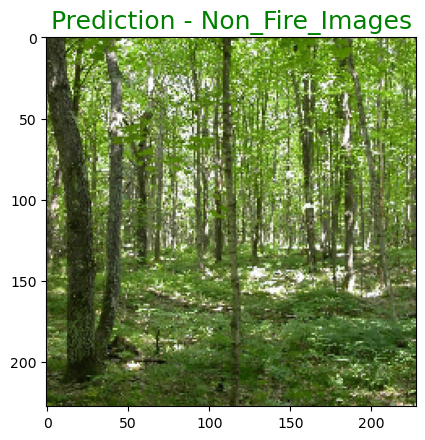

In [54]:
predict_image('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.123.png', model)

1/1 [==============================] - 0s 22ms/step


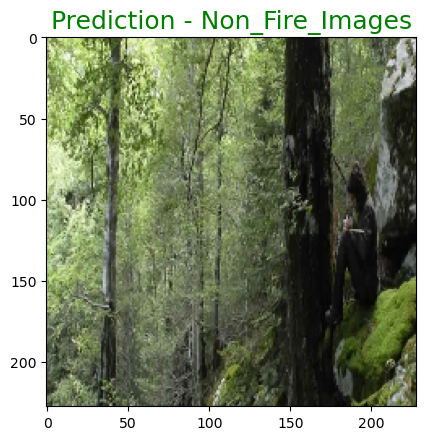

In [55]:
predict_image('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.152.png', model)

1/1 [==============================] - 0s 23ms/step


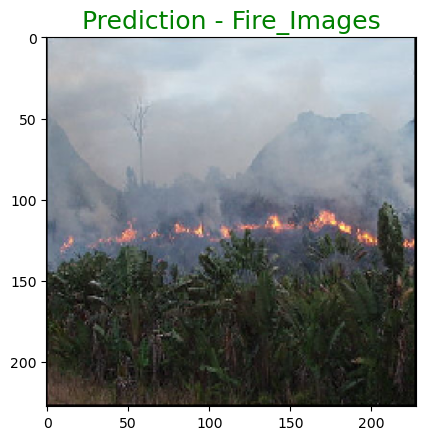

In [56]:
predict_image('/kaggle/input/fire-dataset/fire_dataset/fire_images/fire.110.png', model)

### importing libraries for classification report , accuracy score and confusion matrix

In [39]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Load the saved model
model = tf.keras.models.load_model('fire_image_recognition(inceptionV3).h5')

# Evaluate the model on the original validation data
val_images, val_labels = next(iter(val_data))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


1/1 [==============================] - 0s 481ms/step


### f1 score

In [49]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.89      1.00      0.94         8

    accuracy                           0.97        32
   macro avg       0.94      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



### accuracy score

In [50]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)


Accuracy Score: 0.96875


### confusion matrix

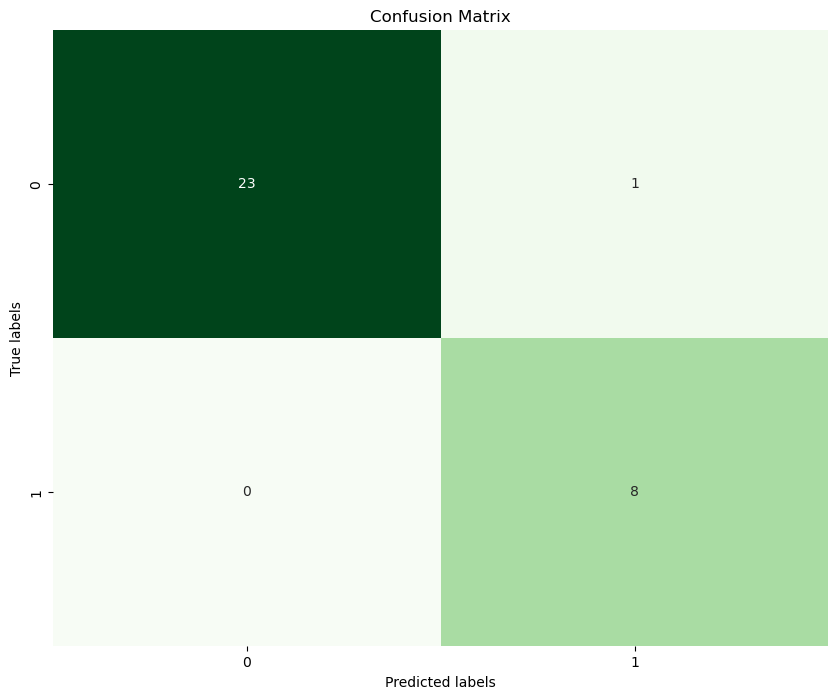

In [51]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
